# 目的

学習した機械学習器の学習・予測データの予測に寄与した特徴量を可視化する

## 機械学習モデルの解釈
SHAPによって、入出力値から、出力に寄与した特徴量をSHAP値で表現できる。  
しかし、前処理でPCAを実施しているため、SHAPで出力される特徴量はPCAのままである。  
このままでは出力に寄与した遺伝子名（生の特徴量）がわからないため、PCAのloading（因子負荷量：主成分と元の特徴量を標準化した変数の相関係数）をSHAPの平均絶対値と内積をとってordinal score：順序スコアを定義する。


In [49]:
# 基本的なライブラリ
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler


from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

# XAI
import shap

# config python file
import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# SHAP

In [50]:
def save_shap_instances(
    shap_explainer: callable,
    shap_values: callable,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    functions.make_dir(save_file_path)
    functions.dill_dump(shap_explainer, "{0}/shap_explainer.pkl".format(save_file_path))
    functions.dill_dump(shap_values, "{0}/shap_values.pkl".format(save_file_path))

In [51]:
def explain_model(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.explainers.Permutation(
        _estimator.predict, _X, max_evals="auto", seed=config.SEED
    )
    """
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        seed=config.SEED,
    )"""
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

In [52]:
def explain_model2(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.explainers.Permutation(
        _estimator.predict, _X, max_evals="auto", seed=config.SEED
    )
    """
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        seed=config.SEED,
    )"""
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

In [53]:
## 全体での実行

In [54]:
# 層別化する特徴量
def exec_shap(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path: ", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

# ランキングの作成

## shap値の取得+pcaを利用した計算

In [55]:
def calc_score(
    model_order_dict: dict(),
) -> pd.DataFrame():
#subgroup_path = "./{0}/{1}/{2}"の./←消す！消さなくてもいけるかも？
    subgroup_path = "{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
        
    plt.title(model_order_dict["subgroup"])
    plt.tight_layout()    
    shap.plots.beeswarm(sv)

    #shap.summary_plot(sv,plot_type='bar')
    
    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )

    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    """
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )
    """
    #MBSPCA用
    loadings = pd.DataFrame(
        pca.components_,
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

In [8]:
preprocess_pipeline = functions.pickle_load(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_MBsparsepca283/test_set/test/preprocess_pipeline.pkl"
                                           )
pca = preprocess_pipeline[-1]
pca

AttributeError: 'MiniBatchSparsePCA' object has no attribute 'max_no_improvement'

AttributeError: 'MiniBatchSparsePCA' object has no attribute 'max_no_improvement'

AttributeError: 'MiniBatchSparsePCA' object has no attribute 'max_no_improvement'

In [9]:
c = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/test/X.pkl"
)
df_pca29 = pd.DataFrame(
    c, columns=pca.get_feature_names_out()
)
display(df_pca29.head())

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/test/X.pkl'

In [4]:
df_gene_expressions = pd.read_pickle(
     config.INTERIM_PREPROCESSED_RECURRENCE_DIR +"/df_gene_expressions.pkl"
)
df_pca29_pca5 = pd.DataFrame(
    pca.components_,
    index=pca.get_feature_names_out(),
    columns=df_gene_expressions.columns,
).T["pca5"].apply(lambda x: abs(x)).sort_values(ascending=False)

df_pca29_pca5 = pd.DataFrame(df_pca29_pca5)
df_pca29_pca5

KeyError: 'pca5'

In [ ]:
 loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        #pca.components_,
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )
l = loadings.T
l_5 = l["pca13"].apply(lambda x: abs(x)).sort_values(ascending=False)
l_5 = pd.DataFrame(l_5)
l_5.rename(columns={'pca13': 'Feature 13'})

In [ ]:
l["pca13"].sort_values(ascending=False)

## 予測で最も性能の高かったパターンでのスコア算出

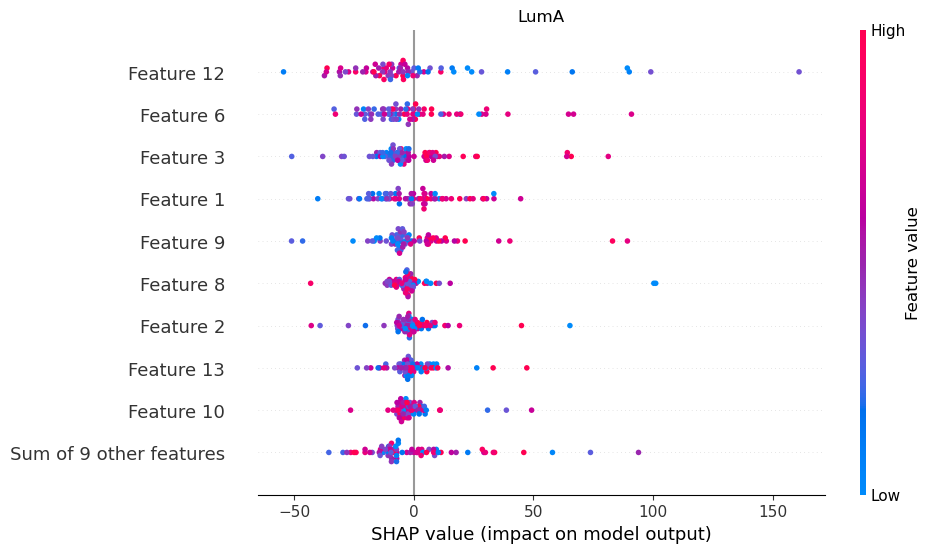

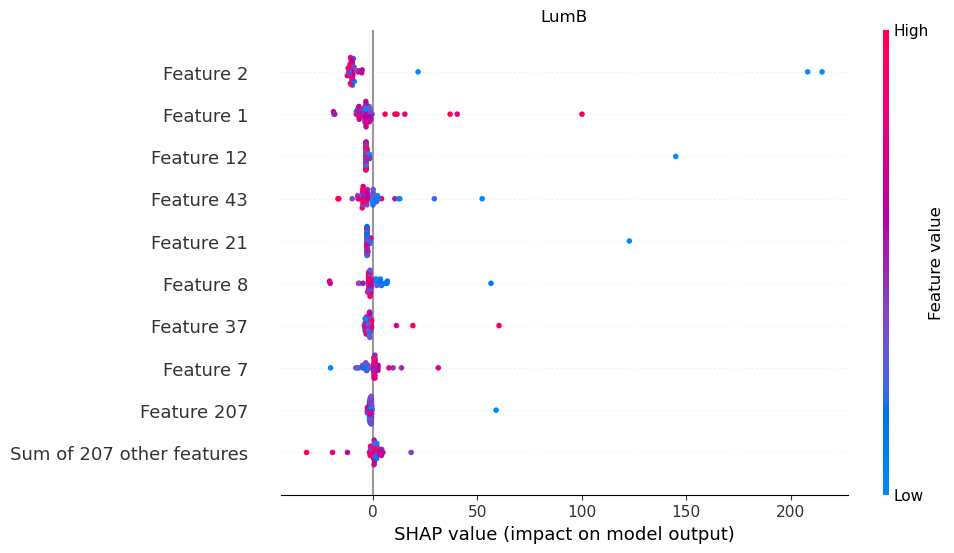

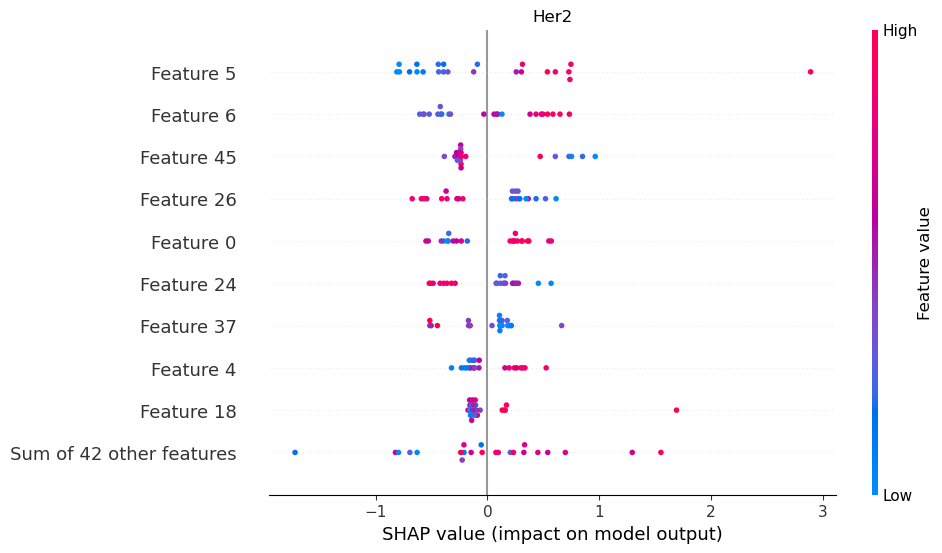

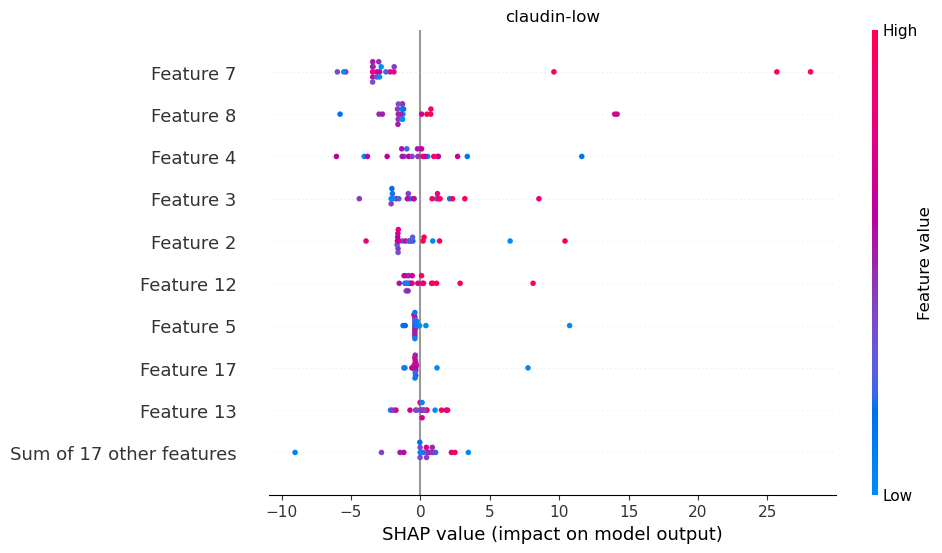

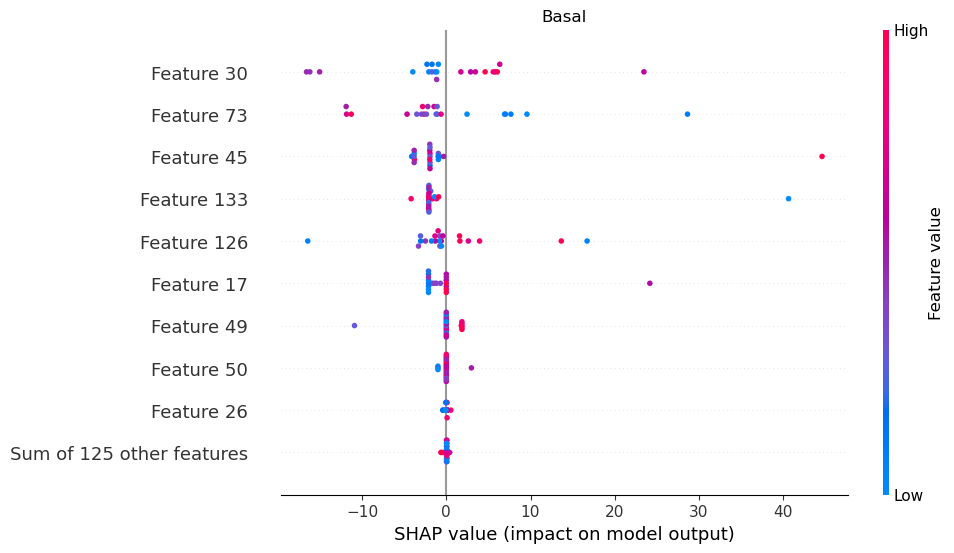

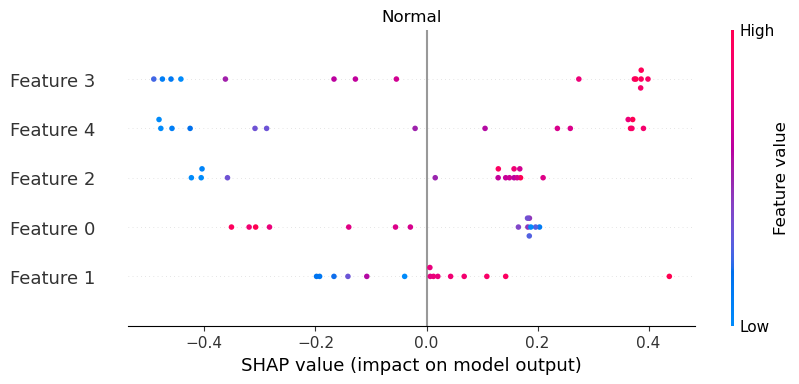

In [29]:
# IncrementalPCA

model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca18",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA = calc_score(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca216",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca51",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2 = calc_score(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca26",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow = calc_score(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca134",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}

rank_Basal = calc_score(model_order_dict)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca5",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal = calc_score(model_order_dict)


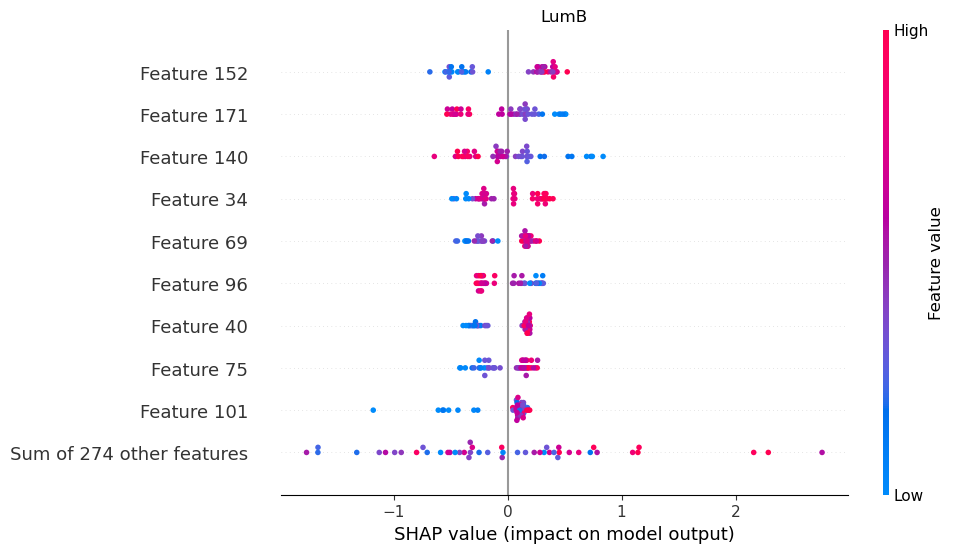

....................................................................................................
model_order_dict name:  RandomSurvivalForest
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_MBSparsepca10/test_set/test
input pipe path:  ./../data/interim/MODELS/RECURRENCE/CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_MBSparsepca10/RandomSurvivalForest/test_set
output file path:  ./../data/interim/EXPLAIN/RECURRENCE/CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_MBSparsepca10/RandomSurvivalForest/test_set
preprocess or pipeline pkl file dose not exist


FileNotFoundError: [Errno 2] No such file or directory: './../data/interim/EXPLAIN/RECURRENCE/CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_MBSparsepca10/RandomSurvivalForest/test_set/shap_values.pkl'

In [17]:
#MBSPCA 
"""
model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca148",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_MBS = calc_score(model_order_dict)
"""

model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBsparsepca283",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_MBS = calc_score(model_order_dict)

"""
model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca94",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_MBS = calc_score(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca9",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_MBS = calc_score(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca18",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_MBS = calc_score(model_order_dict)
"""

model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca10",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_MBS = calc_score(model_order_dict)


In [42]:
model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBsparsepca100",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_LumB_MBS = calc_score(model_order_dict)

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_MBsparsepca100/test_set/test
input pipe path:  ./../data/interim/MODELS/RECURRENCE/CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_MBsparsepca100/GradientBoostingSurvivalAnalysis/test_set
output file path:  ./../data/interim/EXPLAIN/RECURRENCE/CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_MBsparsepca100/GradientBoostingSurvivalAnalysis/test_set
preprocess or pipeline pkl file dose not exist


FileNotFoundError: [Errno 2] No such file or directory: './../data/interim/EXPLAIN/RECURRENCE/CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_MBsparsepca100/GradientBoostingSurvivalAnalysis/test_set/shap_values.pkl'

In [30]:
rank_Her2 = rank_Her2.rename(columns={"gene name": "gene_Her2", "score": "score_Her2"})
df_rank = rank_Her2.copy()
df_rank = pd.merge(df_rank, rank_Her2, right_index=True, left_index=True)
df_rank.to_csv("./explain_score.csv")
df_rank

,gene_Her2_x,score_Her2_x,gene_Her2_y,score_Her2_y
0,FKBP5,0.791952,FKBP5,0.791952
1,MELK,0.784718,MELK,0.784718
2,HERC3,0.770825,HERC3,0.770825
3,AACS,0.762741,AACS,0.762741
4,SCP2,0.760379,SCP2,0.760379
...,...,...,...,...
20598,KRTAP2-2,0.197576,KRTAP2-2,0.197576
20599,SOX21,0.197150,SOX21,0.197150
20600,SCN1A,0.195278,SCN1A,0.195278
20601,LINC02398,0.192697,LINC02398,0.192697


In [31]:
rank_claudinlow = rank_claudinlow.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA = rank_LumA.rename(columns={"gene name": "gene_LumA", "score": "score_LumA"})
rank_LumB = rank_LumB.rename(columns={"gene name": "gene_LumB", "score": "score_LumB"})
rank_Her2 = rank_Her2.rename(columns={"gene name": "gene_Her2", "score": "score_Her2"})
rank_Basal = rank_Basal.rename(columns={"gene name": "gene_Basal", "score": "Basal"})
rank_Normal = rank_Normal.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank = rank_claudinlow.copy()
df_rank = pd.merge(df_rank, rank_LumA, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_LumB, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Her2, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Normal, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Basal, right_index=True, left_index=True)
# 一時的な保存
df_rank.to_csv("./explain_score.csv")
df_rank

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,RAB17,5.960212,ANKRD11,27.147074,DTWD2,19.978872,FKBP5,0.791952,TXNDC9,0.454214,TFE3,3.680925
1,SPDEF,5.717005,DYNLRB1,26.481978,BLZF1,19.773020,MELK,0.784718,SUMO1P3,0.452443,SGMS1,3.629292
2,KRT18P55,5.701024,HSP90AB3P,26.131636,IL17RD,19.683666,HERC3,0.770825,RTRAF,0.450131,SHROOM2,3.578734
3,PPWD1,5.631164,CSNK1G3,25.660056,USP49,19.655475,AACS,0.762741,HNRNPC,0.448844,SATL1,3.532745
4,KRT18,5.600274,HIRIP3,25.554631,MBD4,19.654156,SCP2,0.760379,COPS8,0.448418,FILIP1,3.527801
...,...,...,...,...,...,...,...,...,...,...,...,...
20598,ERAS,0.513006,OR4X2,2.726548,LOC643406,1.150318,KRTAP2-2,0.197576,PLEKHM3,0.023368,NTF4,0.304230
20599,ADRA2C,0.506669,FOLH1B,2.692570,OR2A25,1.120802,SOX21,0.197150,CCDC105,0.022701,PPP1R12B,0.285629
20600,GATA5,0.500762,FSCN3,2.589185,LOC647983,1.106317,SCN1A,0.195278,BC041879,0.022568,ARHGAP9,0.273709
20601,CGB5,0.491767,OR10K1,2.458313,C10orf91,1.061941,LINC02398,0.192697,UGT1A10,0.021956,ITGAL,0.268732


# 晩期再発者のみの調査

In [56]:
# 層別化する特徴量
def exec_shap4late_recurrences(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/late_recurrences",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

In [57]:
# shap_valueをもとにプロット・保存を実施する関数
def plot_sv(sv):
    plt.figure(figsize=(6, 6))
    shap.plots.beeswarm(sv, show=False)
    plt.title(model_order_dict["subgroup"])
    plt.tight_layout()
    
    functions.make_dir(config.FIGURES_EXPLAIN_RECURRENCE_DIR)
    functions.make_dir("{0}/{1}/{2}/{3}/{4}".format(
        config.FIGURES_EXPLAIN_RECURRENCE_DIR,
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
        model_order_dict["model_name"]
    ))


    # プロットを保存（保存先を指定）
    save_path = "{0}/{1}/{2}/{3}/{4}".format(
        config.FIGURES_EXPLAIN_RECURRENCE_DIR,
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
        model_order_dict["model_name"]
    )

    plt.savefig(save_path + "/shap_{0}.png".format(model_order_dict["subgroup"]))


# 晩期再発者向けに定義した順序スコアを計算するための関数
def calc_score4late_recurrences(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap4late_recurrences(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    plot_sv(sv)

    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )
    df_shap = pd.DataFrame(df_shap)
    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )
    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

In [58]:
# shap_valueをもとにプロット・保存を実施する関数、MBSPCA用
def plot_sv(sv):
    plt.figure(figsize=(6, 6))
    shap.plots.beeswarm(sv, show=False)
    plt.title(model_order_dict["subgroup"])
    plt.tight_layout()
    
    functions.make_dir(config.FIGURES_EXPLAIN_RECURRENCE_DIR)
    functions.make_dir("{0}/{1}/{2}/{3}/{4}".format(
        config.FIGURES_EXPLAIN_RECURRENCE_DIR,
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
        model_order_dict["model_name"]
    ))


    # プロットを保存（保存先を指定）
    save_path = "{0}/{1}/{2}/{3}/{4}".format(
        config.FIGURES_EXPLAIN_RECURRENCE_DIR,
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
        model_order_dict["model_name"]
    )

    plt.savefig(save_path + "/shap_{0}.png".format(model_order_dict["subgroup"]))


# 晩期再発者向けに定義した順序スコアを計算するための関数
def calc_score4late_recurrences_MBS(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )    
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap4late_recurrences(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    
    sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    plot_sv(sv)

    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )
    df_shap = pd.DataFrame(df_shap)
    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算

    loadings = pd.DataFrame(
        pca.components_,
        index = pca.get_feature_names_out(),
        columns = pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

In [59]:
def calc_score4late_recurrences_MBS1(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
     
    exec_shap4late_recurrences(model_order_dict)

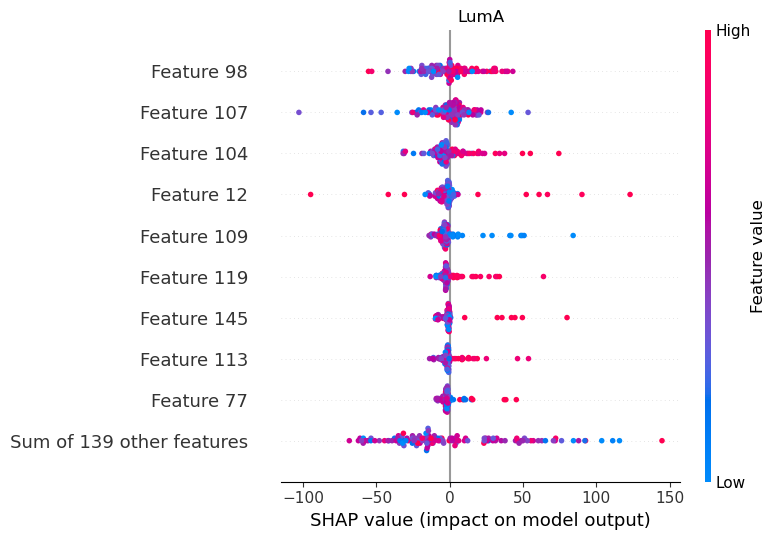

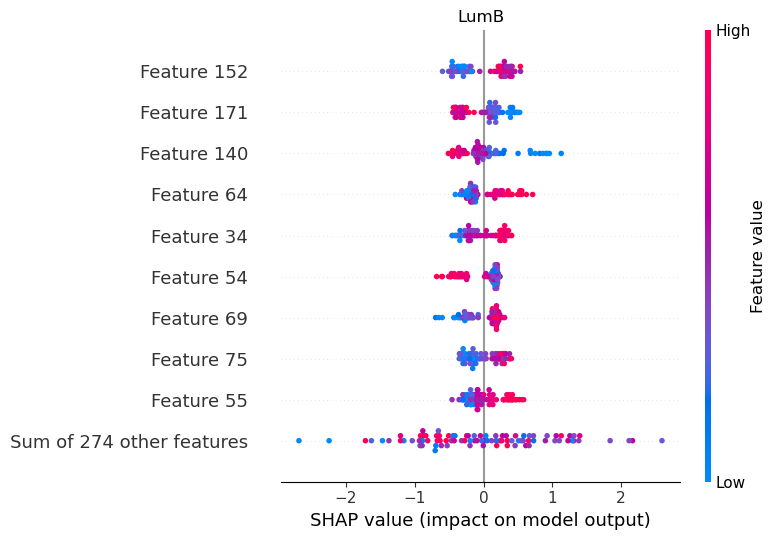

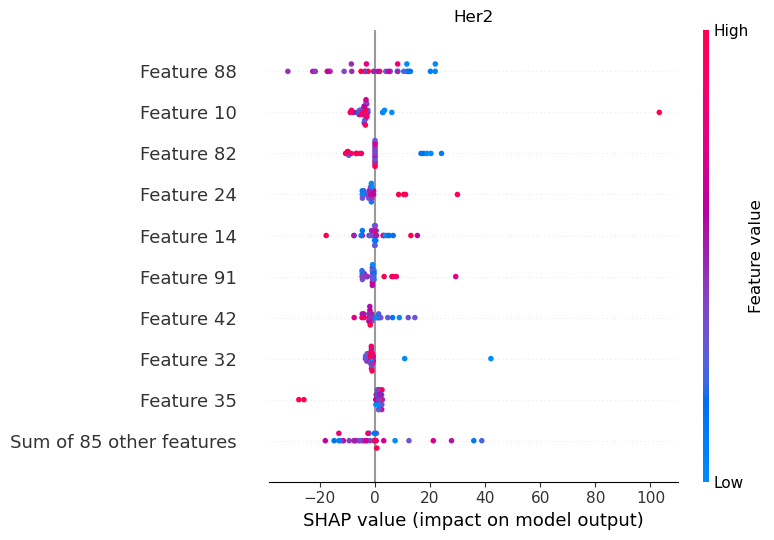

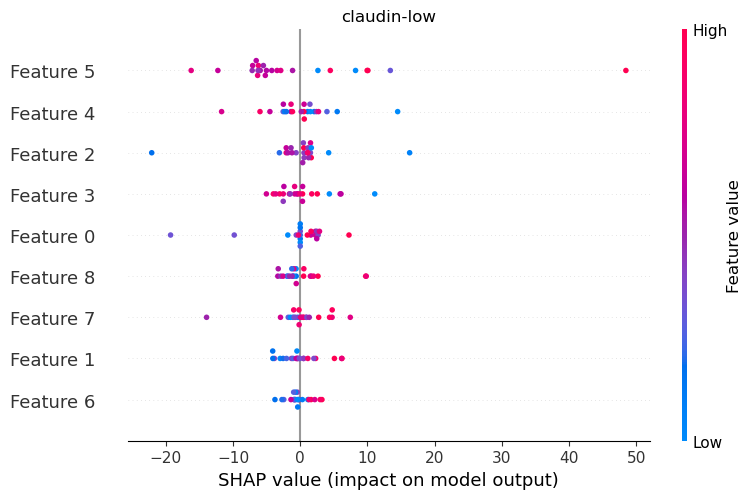

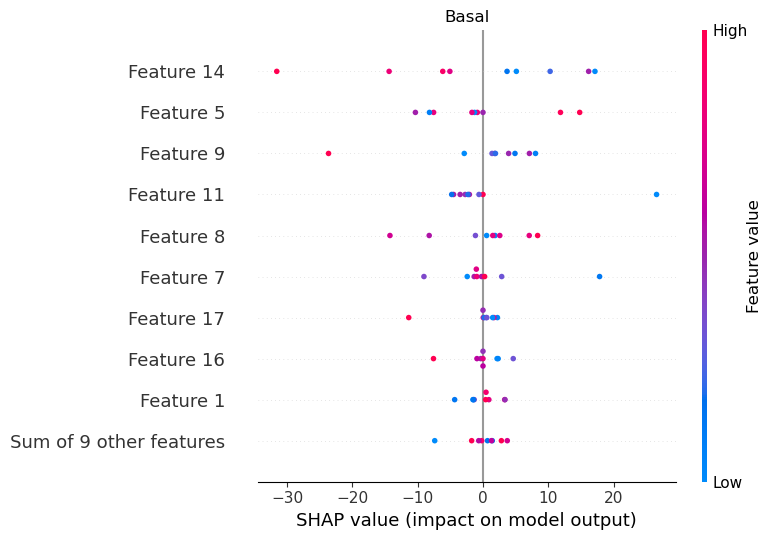

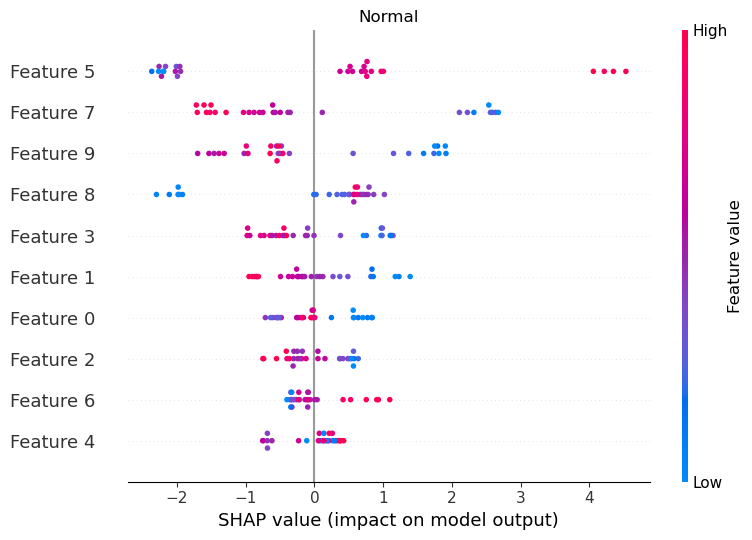

In [60]:
#MBSPCA 

model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca148",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences_MBS(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBsparsepca283",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences_MBS(model_order_dict)



model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca94",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences_MBS(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca9",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences_MBS(
    model_order_dict,
)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBsparsepca18",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}

rank_Basal_late = calc_score4late_recurrences_MBS(model_order_dict)

model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_MBSparsepca10",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences_MBS(model_order_dict)


In [12]:
input_data_path = "./../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_MBSparsepca10/test_set/late_recurrences"
input_pipe_path = "./../data/interim/MODELS/RECURRENCE/CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_MBSparsepca10/RandomSurvivalForest/test_set"
_X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
_y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)

In [13]:
_model_pipeline = functions.pickle_load(
    "{0}/model_pipeline.pkl".format(input_pipe_path)
)

In [61]:
rank_Normal_late

,gene name,score
0,CFAP74,0.118381
1,DDX17,0.116741
2,ZNF14,0.116613
3,EXO5,0.115885
4,METTL21A,0.115371
...,...,...
20598,GCNT2P1,0.000000
20599,LINC02433,0.000000
20600,LINC00994,0.000000
20601,LOC647983,0.000000


In [ ]:
rank_Normal_late[rank_Normal_late["gene name"] == "ARPC5"]

In [ ]:
rank_Her2_late

In [ ]:
rank_Her2_late2

In [12]:
subgroup_path="CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_Incpca5"

# load shap values
pkl_path = "./{0}/{1}/{2}/{3}".format(
    config.INTERIM_EXPLAIN_RECURRENCE_DIR,
    subgroup_path,
    "ExtraSurvivalTrees",
    "test_set/late_recurrences",
)
sv = functions.dill_load(pkl_path + "/shap_values.pkl")

# beeswarm plotに準じたDataFrameの作成
df_shap = pd.DataFrame(
    sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
)

pkl_path = "./{0}/{1}/{2}".format(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
    subgroup_path,
    "test_set/test",
)
preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
pca = preprocess_pipeline[-1]

# 主成分負荷量（loading）の計算
loadings = pd.DataFrame(
    pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
    index=pca.get_feature_names_out(),
    columns=pca.feature_names_in_,
)
# shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
scores = pd.DataFrame(
    np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
).T
ranking = scores.sort_values(by="score", ascending=False)
ranking = ranking.reset_index().rename(columns={"index": "gene name"})

In [13]:
df_shap

,shap abs means
Feature 0,0.194908
Feature 1,0.206869
Feature 2,0.253551
Feature 3,0.343749
Feature 4,0.241192


In [14]:
l = pd.DataFrame(loadings["RERE"])
l

,RERE
incrementalpca0,-0.225252
incrementalpca1,-0.556720
incrementalpca2,-0.188003
incrementalpca3,-0.398186
incrementalpca4,0.195262


In [15]:
ld = np.dot((df_shap).T,abs(l))
ld = pd.DataFrame(ld)
ld

,0
0,0.390711


In [16]:
scores

,score
RERE,0.390711
RNF165,0.234036
PHF7,0.254914
CIDEA,0.131122
TENT2,0.305367
...,...
VPS72,0.178802
CSMD3,0.095290
CC2D1A,0.269121
IGSF9,0.097696


In [17]:
rank_LumB_late

NameError: name 'rank_LumB_late' is not defined

In [18]:
subgroup_column = "CLAUDIN_SUBTYPE"
subgroup = "Normal"
preprocess_name = "NEWpreprocess4numeric_Incpca5"

subgroup_path = "./{0}/{1}/{2}".format(
    subgroup_column,
    subgroup,
    preprocess_name,
)

pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
pca = preprocess_pipeline[-1]
pca

IncrementalPCA(n_components=5)

In [19]:
loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    ).apply(lambda x: abs(x))
loadings = pd.DataFrame(loadings)
i =1
for i in range(5):
    loadings.rename(index={'incrementalpca'+str(i): 'Feature'+str(i)}, inplace=True)
l = loadings.T
l

,Feature0,Feature1,Feature2,Feature3,Feature4
RERE,0.225252,0.556720,0.188003,0.398186,0.195262
RNF165,0.474414,0.435572,0.001169,0.121368,0.039163
PHF7,0.584930,0.090376,0.032927,0.156142,0.249547
CIDEA,0.156553,0.135129,0.175893,0.005621,0.108315
TENT2,0.510040,0.283079,0.240545,0.228377,0.032761
...,...,...,...,...,...
VPS72,0.151240,0.338224,0.077757,0.156625,0.024051
CSMD3,0.083875,0.098291,0.076680,0.034011,0.113916
CC2D1A,0.364679,0.225807,0.382536,0.009645,0.211541
IGSF9,0.284603,0.042238,0.030020,0.013882,0.087497


In [20]:
l_gene=pd.DataFrame(l["Feature3"].sort_values(ascending=False))
print(subgroup)
l_gene

Normal


,Feature3
ETS1,0.791058
ARPC5,0.764802
LAMB1,0.698327
RAB8B,0.690963
CPNE8,0.687454
...,...
CYP2D7P1,0.000113
GALNT18,0.000105
ZMYM4,0.000083
RORB,0.000050


In [21]:
rank_Her2_late

NameError: name 'rank_Her2_late' is not defined

In [22]:
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
df_rank_late = rank_Her2_late.copy()
df_rank_late

NameError: name 'rank_Her2_late' is not defined

In [23]:
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
df_rank_late = rank_Her2_late.copy()
df_rank_late = pd.merge(df_rank_late, rank_Her2_late, right_index=True, left_index=True)
# 一時的な保存
df_rank_late.to_csv("./explain_score_late.csv")
df_rank_late

NameError: name 'rank_Her2_late' is not defined

In [5]:
df_gene_expressions = pd.read_pickle(
     config.INTERIM_PREPROCESSED_RECURRENCE_DIR +"/df_gene_expressions.pkl"
)

preprocess_pipeline = functions.pickle_load(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_Incpca51/test_set/test/preprocess_pipeline.pkl"
                                           )
pca = preprocess_pipeline[-1]
df_51_pca5 = pd.DataFrame(
    pca.components_,
    index=pca.get_feature_names_out(),
    columns=df_gene_expressions.columns,
).T["incrementalpca5"].apply(lambda x: abs(x)).sort_values(ascending=False)

df_51_pca5 = pd.DataFrame(df_51_pca5)
df_51_pca5

,incrementalpca5
Hugo_Symbol,
CHD3,3.374913e-02
GPRACR,3.336705e-02
ICAM1,3.230337e-02
C14orf1,3.211059e-02
MDFI,3.183111e-02
...,...
BAD,2.753580e-06
TM2D2,1.692789e-06
CPA6,1.691522e-06


In [10]:
df_gene_expressions = pd.read_pickle(
     config.INTERIM_PREPROCESSED_RECURRENCE_DIR +"/df_gene_expressions.pkl"
)

preprocess_pipeline = functions.pickle_load(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/LumA/NEWpreprocess4numeric_MBSparsepca148/test_set/test/preprocess_pipeline.pkl"
                                           )
pca = preprocess_pipeline[-1]
df_mbspca98 = pd.DataFrame(
    pca.components_,
    index=pca.get_feature_names_out(),
    columns=df_gene_expressions.columns,
).T["minibatchsparsepca98"].apply(lambda x: abs(x)).sort_values(ascending=False)

print("LumA")
df_mbspca98 = pd.DataFrame(df_mbspca98)
df_mbspca98

LumA


,minibatchsparsepca98
Hugo_Symbol,
GMPS,0.069526
MYOZ3,0.060946
LMLN,0.056825
ANKRD9,0.056316
PLEKHG4B,0.055857
...,...
GAS2,0.000000
PCDHGC4,0.000000
ZFP36,0.000000


In [25]:
loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    ).T["incrementalpca5"].apply(lambda x: abs(x)).sort_values(ascending=False)
loadings = pd.DataFrame(loadings)
loadings

,incrementalpca5
CHD3,0.687823
GPRACR,0.680036
ICAM1,0.658358
C14orf1,0.654428
MDFI,0.648733
...,...
BAD,0.000056
TM2D2,0.000034
CPA6,0.000034
FLJ41455,0.000004


In [26]:
# 修士論文
model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca41",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca43",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca77",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca31",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca30",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca58",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)

NameError: name 'exec_shap4late_recurrences' is not defined

In [14]:
rank_claudinlow_late = rank_claudinlow_late.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA_late = rank_LumA_late.rename(
    columns={"gene name": "gene_LumA", "score": "score_LumA"}
)
rank_LumB_late = rank_LumB_late.rename(
    columns={"gene name": "gene_LumB", "score": "score_LumB"}
)
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
rank_Basal_late = rank_Basal_late.rename(
    columns={"gene name": "gene_Basal", "score": "Basal"}
)
rank_Normal_late = rank_Normal_late.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank_late = rank_claudinlow_late.copy()
df_rank_late = pd.merge(df_rank_late, rank_LumA_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_LumB_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_Her2_late, right_index=True, left_index=True)
df_rank_late = pd.merge(
    df_rank_late, rank_Normal_late, right_index=True, left_index=True
)
df_rank_late = pd.merge(
    df_rank_late, rank_Basal_late, right_index=True, left_index=True
)
# 一時的な保存
df_rank_late.to_csv("./explain_score_late.csv")
df_rank_late

NameError: name 'rank_claudinlow_late' is not defined

In [15]:
df_rank

NameError: name 'df_rank' is not defined

In [ ]:
df_rank_late

In [ ]:
# 層別化する特徴量
def exec_shap4late_recurrences(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/late_recurrences",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

In [ ]:
def explain_model3(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.explainers.Permutation(
        _estimator.predict, _X, max_evals="auto", seed=config.SEED
    )
    """
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        seed=config.SEED,
    )"""
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

## SurvSHAP

 99%|===================| 15556/15664 [01:20<00:00]        

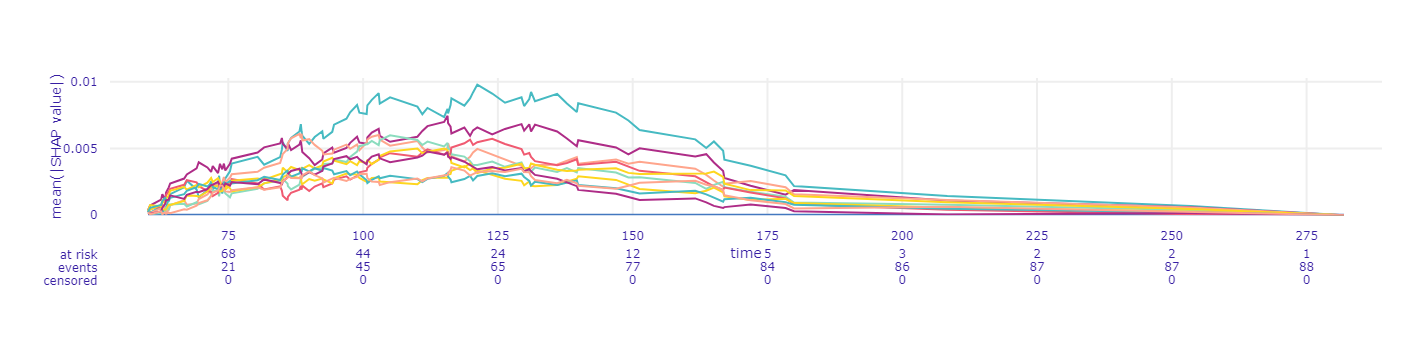

In [18]:
# 必要なライブラリをインポート
from survshap import SurvivalModelExplainer, PredictSurvSHAP, ModelSurvSHAP
from sksurv.ensemble import RandomSurvivalForest # または他の生存分析モデル

subgroup_path="CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_Incpca216"

input_data_path = "./{0}/{1}/{2}".format(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
    subgroup_path,
    "test_set/late_recurrences",
)
input_pipe_path = "./{0}/{1}/{2}/{3}".format(
    config.INTERIM_MODELS_RECURRENCE_DIR,
    subgroup_path,
    "SurvivalTree",
    "test_set",
)


_X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
_y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
_model_pipeline = functions.pickle_load(
    "{0}/model_pipeline.pkl".format(input_pipe_path)
)
_estimator = _model_pipeline[-1]
# データを読み込む

# 生存分析モデルを準備する

_X = pd.DataFrame(_X)
for i in range(216):
    _X = _X.rename(columns ={i:"Feature"+str(i)})

#model = RandomSurvivalForest(random_state=config.SEED)
model = RandomSurvivalForest(
                    n_estimators=1000,
                    min_samples_split=10,
                    min_samples_leaf=15,
                    n_jobs=-1,
                    random_state=config.SEED,
                            )
model.fit(_X, _y)


# Explainerを作成する
explainer = SurvivalModelExplainer(model=model, data=_X, y=_y)

"""
# 1つの観測値に対するSHAP値を計算する
observation_A = _X.iloc[[0]]
survshap_A = PredictSurvSHAP()
survshap_A.fit(explainer=explainer, new_observation=observation_A)
survshap_A.result
survshap_A.plot()
"""

# 複数の観測値に対するSHAP値を計算する
model_survshap = ModelSurvSHAP(calculation_method="treeshap")
model_survshap.fit(explainer= explainer , new_observations = _X)
model_survshap.result
model_survshap.plot_mean_abs_shap_values()
"""
model_survshap.plot_shap_lines_for_all_individuals(variable="variabl1")
"""
extracted_survshap = model_survshap.individual_explanations[0] # PredictSurvSHAP object

In [19]:
model_survshap.result

,variable_name,variable_value,B,aggregated_change,index,t = 60.1,t = 60.49,t = 62.53,t = 62.76,t = 63.29,...,t = 163.65,t = 165.07,t = 166.78,t = 167.01,t = 171.88,t = 178.36,t = 179.93,t = 208.36,t = 253.49,t = 281.94
158,Feature47,6.764540,0.0,0.832717,44.0,0.000366,0.000184,0.000631,0.000115,0.000552,...,0.005033,0.005520,0.004825,0.004151,0.003694,0.002978,0.002180,0.001432,0.000685,0.0
103,Feature191,3.221393,0.0,0.654890,44.0,0.000376,0.000723,0.001160,0.001560,0.001139,...,0.004569,0.003943,0.003310,0.002790,0.002207,0.001533,0.001890,0.001097,0.000597,0.0
111,Feature199,3.695445,0.0,0.525992,44.0,0.000287,0.000147,0.000524,0.000796,0.000503,...,0.003019,0.002595,0.002121,0.002354,0.002562,0.002089,0.001558,0.001135,0.000573,0.0
177,Feature64,6.679090,0.0,0.418421,44.0,0.000286,0.000077,0.000166,0.000105,0.000229,...,0.001972,0.002270,0.002495,0.002093,0.001755,0.001379,0.000948,0.000777,0.000389,0.0
191,Feature77,5.690718,0.0,0.406443,44.0,0.000212,0.000466,0.000658,0.000941,0.001241,...,0.002500,0.002153,0.001892,0.002067,0.001704,0.001260,0.000832,0.000398,0.000066,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,Feature118,4.388690,0.0,0.000000,44.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
24,Feature12,10.593257,0.0,0.000000,44.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
31,Feature126,4.562488,0.0,0.000000,44.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
118,Feature204,3.819030,0.0,0.000000,44.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [4]:
model_survshap.result

,variable_name,variable_value,B,aggregated_change,index,t = 60.1,t = 60.49,t = 62.53,t = 62.76,t = 63.29,...,t = 163.65,t = 165.07,t = 166.78,t = 167.01,t = 171.88,t = 178.36,t = 179.93,t = 208.36,t = 253.49,t = 281.94
111,Feature199,3.695445,0.0,1.131980,44.0,0.000497,0.000395,0.000629,0.000885,0.000794,...,0.007496,0.006766,0.005520,0.006011,0.006897,0.005612,0.004319,0.003229,0.001521,0.0
137,Feature28,7.726549,0.0,1.004316,44.0,0.001058,0.001682,0.001278,0.000996,0.001718,...,0.003760,0.002887,0.002327,0.002502,0.002197,0.001624,0.001135,0.000562,0.000000,0.0
158,Feature47,6.764540,0.0,0.916378,44.0,0.000260,0.000260,0.000426,0.000378,0.000493,...,0.006962,0.007079,0.006291,0.005477,0.005106,0.004024,0.003531,0.002175,0.000750,0.0
1,Feature1,21.464354,0.0,0.835942,44.0,0.000200,0.000385,0.000503,0.000686,0.001395,...,0.003290,0.003061,0.002755,0.002502,0.002151,0.001961,0.001373,0.001012,0.000349,0.0
197,Feature82,5.097155,0.0,0.792918,44.0,0.001086,0.001012,0.002327,0.002255,0.002149,...,0.002593,0.002212,0.001701,0.001572,0.001826,0.001685,0.001273,0.000756,0.000308,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,Feature67,5.208701,0.0,0.036053,44.0,0.000000,0.000000,0.000000,0.000146,0.000146,...,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
87,Feature177,3.587400,0.0,0.031789,44.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,Feature106,4.244449,0.0,0.018326,44.0,0.000000,0.000000,0.000000,0.000000,0.000225,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
136,Feature27,7.842516,0.0,0.017264,44.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [70]:
# 必要なライブラリをインポート
from survshap import SurvivalModelExplainer, PredictSurvSHAP, ModelSurvSHAP
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.tree import SurvivalTree
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis

subgroup_path="CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_Incpca51"

input_data_path = "./{0}/{1}/{2}".format(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
    subgroup_path,
    "test_set/late_recurrences",
)

_X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
_y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)

# データを読み込む

# 生存分析モデルを準備する

_X = pd.DataFrame(_X)
for i in range(len(_X.T)):
    _X = _X.rename(columns ={i:"Feature"+str(i)})

"""
model = RandomSurvivalForest(
                    n_estimators=1000,
                    min_samples_split=10,
                    min_samples_leaf=15,
                    n_jobs=-1,
                    random_state=config.SEED,
                            )



#model = SurvivalTree(random_state=config.SEED)
model = GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED)
                


model =  ExtraSurvivalTrees(
                    random_state=config.SEED,
                    n_estimators=1000,
                    min_samples_split=10,
                    min_samples_leaf=15,
                    n_jobs=-1,
                )
"""
model = CoxPHSurvivalAnalysis()
            

model.fit(_X, _y)

# Explainerを作成する
explainer = SurvivalModelExplainer(model= model, data=_X, y=_y)

"""
# 1つの観測値に対するSHAP値を計算する
observation_A = _X.iloc[[0]]
survshap_A = PredictSurvSHAP()
survshap_A.fit(explainer=explainer, new_observation=observation_A)
survshap_A.result
survshap_A.plot()
"""

# 複数の観測値に対するSHAP値を計算する
model_survshap = ModelSurvSHAP(calculation_method="treeshap")
model_survshap.fit(explainer= explainer , new_observations = _X)
model_survshap.result
model_survshap.plot_mean_abs_shap_values()
"""
model_survshap.plot_shap_lines_for_all_individuals(variable="variabl1")
"""
extracted_survshap = model_survshap.individual_explanations[0] # PredictSurvSHAP object

AttributeError: 'CoxPHSurvivalAnalysis' object has no attribute 'estimators_'

In [71]:
model = CoxPHSurvivalAnalysis()
model.estimators_

AttributeError: 'CoxPHSurvivalAnalysis' object has no attribute 'estimators_'

In [67]:
model_survshap.result

,variable_name,variable_value,B,aggregated_change,index,t = 61.15,t = 62.27,t = 62.66,t = 62.96,t = 64.21,...,t = 123.68,t = 124.11,t = 126.02,t = 139.84,t = 143.68,t = 151.22,t = 169.61,t = 170.23,t = 170.63,t = 213.19
0,Feature0,25.115548,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Feature1,23.662107,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Feature2,22.755000,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Feature3,22.166126,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Feature4,16.283679,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
model_survshap.result
pca = "MBS"
subgroup = "LumA"
output_data_path ="./../reports/CSV/"
model_survshap.result.to_csv(output_data_path + "SurvSHAP_{0}_{1}.csv".format(pca, subgroup))

In [45]:
len(_X)

122

In [25]:
model_survshap.result

,variable_name,variable_value,B,aggregated_change,index,t = 61.15,t = 62.27,t = 62.66,t = 62.96,t = 64.21,...,t = 123.68,t = 124.11,t = 126.02,t = 139.84,t = 143.68,t = 151.22,t = 169.61,t = 170.23,t = 170.63,t = 213.19
0,Feature0,20.744111,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Feature1,14.597625,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Feature2,16.054988,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Feature3,11.020672,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Feature4,26.877809,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Feature5,15.214402,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Feature6,16.264995,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Feature7,17.046832,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Feature8,15.178650,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Feature9,17.137094,0.0,0.0,13.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


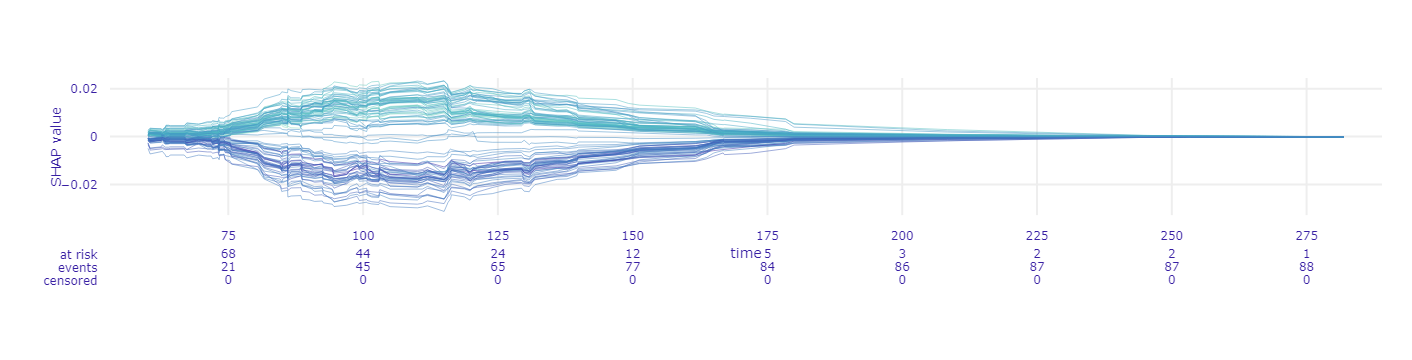

In [91]:
model_survshap.plot_shap_lines_for_all_individuals(variable="Feature28")

In [184]:
from scipy.integrate import trapezoid
def get_orderings_and_ranks_shap(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result.copy()
        df["aggregated_change"] = trapezoid(np.abs(df.iloc[:, 6:].values), explanation.timestamps)
        importance_orderings.append(df.sort_values(by="aggregated_change", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.aggregated_change).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

rsf_survshap_orderings, rsf_survshap_ranks = get_orderings_and_ranks_shap(model_survshap.individual_explanations)

def prepare_ranking_summary_long(ordering):
    res = pd.DataFrame(columns=[0, 1, 2, 3, 4, 5, 6, 7])
    for i in range(8):
        tmp = pd.DataFrame(ordering[i].value_counts().to_dict(), index=[i+1])
        res = pd.concat([res, tmp])
    res = res.reset_index().rename(columns=dict(zip([i for i in range(8)] + ["index"], X.columns.to_list() + ["importance_ranking"])))
    return res.melt(id_vars=["importance_ranking"], value_vars=X.columns)

In [192]:
rsf_survshap_orderings

In [186]:
rsf_survshap_ranks

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,67.0,27.0,163.0,74.0,21.0,3.0,94.0,131.0,29.0,176.0,...,174.0,81.0,150.0,197.0,90.0,71.0,63.0,203.0,75.0,99.0
1,158.0,13.0,204.0,84.0,9.0,33.0,153.0,64.0,48.0,197.0,...,156.0,100.0,124.0,130.0,83.0,140.0,71.0,162.0,56.0,177.0
2,108.0,24.0,206.0,44.0,13.0,11.0,80.0,97.0,2.0,205.0,...,87.0,133.0,117.0,113.0,59.0,112.0,147.0,162.0,123.0,166.0
3,95.0,8.0,202.0,39.0,25.0,10.0,159.0,36.0,81.0,204.0,...,124.0,84.0,104.0,102.0,54.0,151.0,119.0,134.0,52.0,115.0
4,46.0,48.0,183.0,166.0,13.0,67.0,157.0,86.0,33.0,159.0,...,125.0,182.0,143.0,95.0,1.0,71.0,180.0,134.0,119.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,89.0,12.0,72.0,152.0,94.0,35.0,153.0,47.0,38.0,157.0,...,93.0,108.0,58.0,66.0,73.0,59.0,88.0,130.0,67.0,117.0
85,11.0,16.0,141.0,77.0,22.0,23.0,144.0,100.0,38.0,182.0,...,168.0,115.0,170.0,101.0,75.0,128.0,133.0,200.0,7.0,175.0
86,108.0,1.0,198.0,25.0,18.0,20.0,148.0,35.0,68.0,166.0,...,9.0,168.0,23.0,84.0,4.0,82.0,152.0,172.0,91.0,98.0
87,40.0,17.0,196.0,57.0,9.0,24.0,159.0,129.0,37.0,211.0,...,154.0,169.0,153.0,44.0,61.0,156.0,199.0,193.0,15.0,88.0


In [131]:
df = model_survshap.individual_explanations[0].result
df

,variable_str,variable_name,variable_value,B,aggregated_change,index,t = 60.1,t = 60.49,t = 62.53,t = 62.76,...,t = 163.65,t = 165.07,t = 166.78,t = 167.01,t = 171.88,t = 178.36,t = 179.93,t = 208.36,t = 253.49,t = 281.94
0,Feature0 = 114.0,Feature0,113.951038,0,0.263744,0,-6.554306e-05,-1.685392e-05,3.196005e-04,3.196005e-04,...,0.000571,0.000571,-0.000118,-0.000118,-0.000137,-0.000156,-0.000069,0.000018,0.000012,0.0
1,Feature1 = -5.085,Feature1,-5.085180,0,0.532201,0,-8.302121e-05,-2.234707e-04,-2.671660e-04,-5.349563e-04,...,0.001544,0.001156,0.001024,0.000928,0.000710,0.000587,0.000484,0.000478,0.000217,0.0
2,Feature2 = -12.58,Feature2,-12.581768,0,0.072619,0,0.000000e+00,0.000000e+00,-4.213483e-05,-4.213483e-05,...,0.000461,0.000461,0.000307,0.000307,0.000232,0.000232,0.000232,0.000232,0.000154,0.0
3,Feature3 = 24.7,Feature3,24.701971,0,0.246775,0,0.000000e+00,-1.123595e-04,-1.123595e-04,1.123595e-04,...,-0.000637,-0.001245,-0.001308,-0.001909,-0.001580,-0.001580,-0.001282,-0.000763,-0.000298,0.0
4,Feature4 = -11.14,Feature4,-11.137194,0,0.633501,0,1.170412e-04,3.277154e-05,4.522471e-04,1.444756e-03,...,0.000535,0.001184,0.001184,0.001603,0.001463,0.001463,0.001368,0.000777,0.000591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Feature211 = 0.3376,Feature211,0.337574,0,0.257297,0,1.354557e-04,1.791511e-04,2.334582e-04,2.877653e-04,...,0.000906,0.000906,0.000895,0.000836,0.001042,0.001004,0.001231,0.000955,0.000653,0.0
212,Feature212 = 8.562,Feature212,8.562169,0,0.285757,0,-1.674288e-12,-1.674288e-12,-1.674288e-12,-1.674288e-12,...,0.001014,0.000781,0.000781,0.000775,0.000775,0.000581,0.000581,0.000387,0.000194,0.0
213,Feature213 = 5.096,Feature213,5.095517,0,0.024885,0,-1.872658e-06,-1.872658e-06,2.303371e-04,5.555557e-05,...,0.000123,0.000123,0.000123,0.000123,0.000101,0.000076,0.000062,0.000041,0.000021,0.0
214,Feature214 = 10.01,Feature214,10.013998,0,0.243656,0,-1.872659e-05,-1.872659e-05,-1.872659e-05,5.112359e-04,...,0.000876,0.000527,0.000526,0.000205,0.000161,0.000134,0.000101,0.000060,0.000014,0.0


In [132]:
df["aggregated_change"] = trapezoid(np.abs(df.iloc[:, 6:].values), model_survshap.individual_explanations[0].timestamps)
df

,variable_str,variable_name,variable_value,B,aggregated_change,index,t = 60.1,t = 60.49,t = 62.53,t = 62.76,...,t = 163.65,t = 165.07,t = 166.78,t = 167.01,t = 171.88,t = 178.36,t = 179.93,t = 208.36,t = 253.49,t = 281.94
0,Feature0 = 114.0,Feature0,113.951038,0,0.263744,0,-6.554306e-05,-1.685392e-05,3.196005e-04,3.196005e-04,...,0.000571,0.000571,-0.000118,-0.000118,-0.000137,-0.000156,-0.000069,0.000018,0.000012,0.0
1,Feature1 = -5.085,Feature1,-5.085180,0,0.532201,0,-8.302121e-05,-2.234707e-04,-2.671660e-04,-5.349563e-04,...,0.001544,0.001156,0.001024,0.000928,0.000710,0.000587,0.000484,0.000478,0.000217,0.0
2,Feature2 = -12.58,Feature2,-12.581768,0,0.072619,0,0.000000e+00,0.000000e+00,-4.213483e-05,-4.213483e-05,...,0.000461,0.000461,0.000307,0.000307,0.000232,0.000232,0.000232,0.000232,0.000154,0.0
3,Feature3 = 24.7,Feature3,24.701971,0,0.246775,0,0.000000e+00,-1.123595e-04,-1.123595e-04,1.123595e-04,...,-0.000637,-0.001245,-0.001308,-0.001909,-0.001580,-0.001580,-0.001282,-0.000763,-0.000298,0.0
4,Feature4 = -11.14,Feature4,-11.137194,0,0.633501,0,1.170412e-04,3.277154e-05,4.522471e-04,1.444756e-03,...,0.000535,0.001184,0.001184,0.001603,0.001463,0.001463,0.001368,0.000777,0.000591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Feature211 = 0.3376,Feature211,0.337574,0,0.257297,0,1.354557e-04,1.791511e-04,2.334582e-04,2.877653e-04,...,0.000906,0.000906,0.000895,0.000836,0.001042,0.001004,0.001231,0.000955,0.000653,0.0
212,Feature212 = 8.562,Feature212,8.562169,0,0.285757,0,-1.674288e-12,-1.674288e-12,-1.674288e-12,-1.674288e-12,...,0.001014,0.000781,0.000781,0.000775,0.000775,0.000581,0.000581,0.000387,0.000194,0.0
213,Feature213 = 5.096,Feature213,5.095517,0,0.024885,0,-1.872658e-06,-1.872658e-06,2.303371e-04,5.555557e-05,...,0.000123,0.000123,0.000123,0.000123,0.000101,0.000076,0.000062,0.000041,0.000021,0.0
214,Feature214 = 10.01,Feature214,10.013998,0,0.243656,0,-1.872659e-05,-1.872659e-05,-1.872659e-05,5.112359e-04,...,0.000876,0.000527,0.000526,0.000205,0.000161,0.000134,0.000101,0.000060,0.000014,0.0


In [190]:
importance_orderings = []
importance_orderings.append(df.sort_values(by="aggregated_change", key=lambda x: -abs(x)).index.to_list())
importance_orderings = pd.DataFrame(importance_orderings)
importance_orderings

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,47,196,5,66,77,28,82,192,199,105,...,25,123,128,136,115,30,177,139,106,204


In [183]:
df.sort_values(by="aggregated_change",ascending = False)

,variable_str,variable_name,variable_value,B,aggregated_change,index,t = 60.1,t = 60.49,t = 62.53,t = 62.76,...,t = 163.65,t = 165.07,t = 166.78,t = 167.01,t = 171.88,t = 178.36,t = 179.93,t = 208.36,t = 253.49,t = 281.94
47,Feature47 = -6.491,Feature47,-6.490961,0,1.686330,0,-0.000130,-0.000130,0.000137,0.000070,...,0.009723,0.009948,0.009025,0.007156,0.007925,0.006387,0.005396,0.003090,0.000807,0.0
196,Feature196 = 11.56,Feature196,11.558129,0,1.678428,0,0.000083,0.000192,0.000864,0.000498,...,-0.008683,-0.008223,-0.007829,-0.007776,-0.007511,-0.007363,-0.007144,-0.004763,-0.002381,0.0
5,Feature5 = -19.3,Feature5,-19.298794,0,1.263768,0,0.000705,0.000875,0.000994,0.000994,...,0.006563,0.004806,0.002507,0.003384,0.000952,0.001047,0.000629,0.001410,0.002432,0.0
66,Feature66 = 9.986,Feature66,9.985985,0,1.250995,0,-0.000028,0.000088,0.001016,0.001169,...,0.007971,0.007812,0.007305,0.005728,0.005716,0.005422,0.004161,0.002060,0.002101,0.0
77,Feature77 = -4.882,Feature77,-4.882068,0,1.144791,0,0.000268,0.000268,0.000525,0.000494,...,0.007461,0.006921,0.006181,0.006098,0.005656,0.003574,0.002714,0.001795,0.000078,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,Feature30 = 0.5821,Feature30,0.582140,0,0.015024,0,0.000000,0.000000,0.000000,0.000000,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000000,0.0
177,Feature177 = -1.275,Feature177,-1.274908,0,0.014845,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
139,Feature139 = 3.758,Feature139,3.758329,0,0.013029,0,0.000000,0.000000,-0.000056,-0.000056,...,0.000013,0.000007,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
106,Feature106 = 3.281,Feature106,3.281014,0,0.009163,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [182]:
df.sort_values(by="aggregated_change", key=lambda x: -abs(x))

,variable_str,variable_name,variable_value,B,aggregated_change,index,t = 60.1,t = 60.49,t = 62.53,t = 62.76,...,t = 163.65,t = 165.07,t = 166.78,t = 167.01,t = 171.88,t = 178.36,t = 179.93,t = 208.36,t = 253.49,t = 281.94
47,Feature47 = -6.491,Feature47,-6.490961,0,1.686330,0,-0.000130,-0.000130,0.000137,0.000070,...,0.009723,0.009948,0.009025,0.007156,0.007925,0.006387,0.005396,0.003090,0.000807,0.0
196,Feature196 = 11.56,Feature196,11.558129,0,1.678428,0,0.000083,0.000192,0.000864,0.000498,...,-0.008683,-0.008223,-0.007829,-0.007776,-0.007511,-0.007363,-0.007144,-0.004763,-0.002381,0.0
5,Feature5 = -19.3,Feature5,-19.298794,0,1.263768,0,0.000705,0.000875,0.000994,0.000994,...,0.006563,0.004806,0.002507,0.003384,0.000952,0.001047,0.000629,0.001410,0.002432,0.0
66,Feature66 = 9.986,Feature66,9.985985,0,1.250995,0,-0.000028,0.000088,0.001016,0.001169,...,0.007971,0.007812,0.007305,0.005728,0.005716,0.005422,0.004161,0.002060,0.002101,0.0
77,Feature77 = -4.882,Feature77,-4.882068,0,1.144791,0,0.000268,0.000268,0.000525,0.000494,...,0.007461,0.006921,0.006181,0.006098,0.005656,0.003574,0.002714,0.001795,0.000078,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,Feature30 = 0.5821,Feature30,0.582140,0,0.015024,0,0.000000,0.000000,0.000000,0.000000,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000000,0.0
177,Feature177 = -1.275,Feature177,-1.274908,0,0.014845,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
139,Feature139 = 3.758,Feature139,3.758329,0,0.013029,0,0.000000,0.000000,-0.000056,-0.000056,...,0.000013,0.000007,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
106,Feature106 = 3.281,Feature106,3.281014,0,0.009163,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [191]:
importance_ranks =[]
importance_ranks.append(np.abs(df.aggregated_change).rank(ascending=False).to_list())
importance_ranks = pd.DataFrame(importance_ranks)
importance_ranks

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,67.0,27.0,163.0,74.0,21.0,3.0,94.0,131.0,29.0,176.0,...,174.0,81.0,150.0,197.0,90.0,71.0,63.0,203.0,75.0,99.0


In [163]:
df.aggregated_change.rank(ascending=False)

0       67.0
1       27.0
2      163.0
3       74.0
4       21.0
       ...  
211     71.0
212     63.0
213    203.0
214     75.0
215     99.0
Name: aggregated_change, Length: 216, dtype: float64

In [108]:
rsf_survshap_ranks

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,67.0,27.0,163.0,74.0,21.0,3.0,94.0,131.0,29.0,176.0,...,174.0,81.0,150.0,197.0,90.0,71.0,63.0,203.0,75.0,99.0
1,158.0,13.0,204.0,84.0,9.0,33.0,153.0,64.0,48.0,197.0,...,156.0,100.0,124.0,130.0,83.0,140.0,71.0,162.0,56.0,177.0
2,108.0,24.0,206.0,44.0,13.0,11.0,80.0,97.0,2.0,205.0,...,87.0,133.0,117.0,113.0,59.0,112.0,147.0,162.0,123.0,166.0
3,95.0,8.0,202.0,39.0,25.0,10.0,159.0,36.0,81.0,204.0,...,124.0,84.0,104.0,102.0,54.0,151.0,119.0,134.0,52.0,115.0
4,46.0,48.0,183.0,166.0,13.0,67.0,157.0,86.0,33.0,159.0,...,125.0,182.0,143.0,95.0,1.0,71.0,180.0,134.0,119.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,89.0,12.0,72.0,152.0,94.0,35.0,153.0,47.0,38.0,157.0,...,93.0,108.0,58.0,66.0,73.0,59.0,88.0,130.0,67.0,117.0
85,11.0,16.0,141.0,77.0,22.0,23.0,144.0,100.0,38.0,182.0,...,168.0,115.0,170.0,101.0,75.0,128.0,133.0,200.0,7.0,175.0
86,108.0,1.0,198.0,25.0,18.0,20.0,148.0,35.0,68.0,166.0,...,9.0,168.0,23.0,84.0,4.0,82.0,152.0,172.0,91.0,98.0
87,40.0,17.0,196.0,57.0,9.0,24.0,159.0,129.0,37.0,211.0,...,154.0,169.0,153.0,44.0,61.0,156.0,199.0,193.0,15.0,88.0


NameError: name 'df' is not defined

In [84]:
extracted_survshap1 = model_survshap.individual_explanations[88]
extracted_survshap1

,variable_name,variable_value,B,aggregated_change
0,Feature0,50.540004,0,0.232113
1,Feature1,13.533880,0,0.477765
2,Feature2,16.557254,0,0.215778
3,Feature3,-43.388129,0,0.243367
4,Feature4,-17.297874,0,0.722133
...,...,...,...,...
211,Feature211,-6.230173,0,0.207243
212,Feature212,9.339955,0,0.364029
213,Feature213,9.936440,0,0.141434
214,Feature214,4.000244,0,0.243400


In [112]:
survshap_result

,variable_name,variable_value,B,aggregated_change,index,t = 60.1,t = 60.49,t = 62.53,t = 62.76,t = 63.29,...,t = 163.65,t = 165.07,t = 166.78,t = 167.01,t = 171.88,t = 178.36,t = 179.93,t = 208.36,t = 253.49,t = 281.94
111,Feature199,3.695445,0.0,1.131980,44.0,0.000497,0.000395,0.000629,0.000885,0.000794,...,0.007496,0.006766,0.005520,0.006011,0.006897,0.005612,0.004319,0.003229,0.001521,0.0
137,Feature28,7.726549,0.0,1.004316,44.0,0.001058,0.001682,0.001278,0.000996,0.001718,...,0.003760,0.002887,0.002327,0.002502,0.002197,0.001624,0.001135,0.000562,0.000000,0.0
158,Feature47,6.764540,0.0,0.916378,44.0,0.000260,0.000260,0.000426,0.000378,0.000493,...,0.006962,0.007079,0.006291,0.005477,0.005106,0.004024,0.003531,0.002175,0.000750,0.0
1,Feature1,21.464354,0.0,0.835942,44.0,0.000200,0.000385,0.000503,0.000686,0.001395,...,0.003290,0.003061,0.002755,0.002502,0.002151,0.001961,0.001373,0.001012,0.000349,0.0
197,Feature82,5.097155,0.0,0.792918,44.0,0.001086,0.001012,0.002327,0.002255,0.002149,...,0.002593,0.002212,0.001701,0.001572,0.001826,0.001685,0.001273,0.000756,0.000308,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,Feature67,5.208701,0.0,0.036053,44.0,0.000000,0.000000,0.000000,0.000146,0.000146,...,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
87,Feature177,3.587400,0.0,0.031789,44.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,Feature106,4.244449,0.0,0.018326,44.0,0.000000,0.000000,0.000000,0.000000,0.000225,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
136,Feature27,7.842516,0.0,0.017264,44.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [110]:
survshap_result = model_survshap.result
survshap_result.sort_values('variable_value', ascending=False)

,variable_name,variable_value,B,aggregated_change,index,t = 60.1,t = 60.49,t = 62.53,t = 62.76,t = 63.29,...,t = 163.65,t = 165.07,t = 166.78,t = 167.01,t = 171.88,t = 178.36,t = 179.93,t = 208.36,t = 253.49,t = 281.94
0,Feature0,30.124704,0.0,0.286718,44.0,1.138605e-04,1.751603e-04,6.744350e-04,6.577424e-04,6.577424e-04,...,0.000473,0.000473,0.000515,0.000515,0.000496,0.000494,0.000376,0.000264,0.000026,0.0
112,Feature2,22.364285,0.0,0.078893,44.0,0.000000e+00,0.000000e+00,1.688549e-04,1.688549e-04,1.688549e-04,...,0.000520,0.000520,0.000347,0.000347,0.000303,0.000303,0.000303,0.000303,0.000173,0.0
1,Feature1,21.464354,0.0,0.835942,44.0,1.996942e-04,3.846491e-04,5.030551e-04,6.864820e-04,1.395049e-03,...,0.003290,0.003061,0.002755,0.002502,0.002151,0.001961,0.001373,0.001012,0.000349,0.0
139,Feature3,18.942955,0.0,0.227374,44.0,2.257467e-13,1.431322e-04,1.431322e-04,2.728401e-04,2.728401e-04,...,0.001230,0.001215,0.001198,0.001244,0.000872,0.000872,0.000714,0.000314,0.000160,0.0
150,Feature4,16.469166,0.0,0.511155,44.0,2.306106e-04,1.959980e-04,8.508675e-04,1.616774e-03,2.121603e-03,...,0.001301,0.001210,0.001210,0.001316,0.001040,0.001040,0.000923,0.000613,0.000322,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,Feature158,3.346880,0.0,0.152553,44.0,4.797117e-13,1.662528e-04,1.662528e-04,1.662528e-04,1.662528e-04,...,0.000568,0.000652,0.000443,0.000486,0.000389,0.000235,0.000235,0.000124,0.000111,0.0
107,Feature195,3.339291,0.0,0.224755,44.0,1.150247e-04,1.618412e-04,5.417736e-04,5.272342e-04,5.239869e-04,...,0.001161,0.000845,0.000851,0.000724,0.000724,0.000497,0.000405,0.000314,0.000147,0.0
103,Feature191,3.221393,0.0,0.683249,44.0,2.240878e-04,4.487368e-04,1.715089e-03,2.117963e-03,2.114316e-03,...,0.003662,0.003118,0.002599,0.002357,0.001850,0.001310,0.001484,0.000909,0.000254,0.0
127,Feature212,3.193376,0.0,0.102065,44.0,1.185170e-12,1.185170e-12,1.185170e-12,1.185170e-12,1.185170e-12,...,0.000544,0.000365,0.000365,0.000327,0.000327,0.000245,0.000245,0.000163,0.000082,0.0


In [74]:
extracted_survshap

,variable_name,variable_value,B,aggregated_change
0,Feature0,113.951038,0,0.263744
1,Feature1,-5.085180,0,0.532201
2,Feature2,-12.581768,0,0.072619
3,Feature3,24.701971,0,0.246775
4,Feature4,-11.137194,0,0.633501
...,...,...,...,...
211,Feature211,0.337574,0,0.257297
212,Feature212,8.562169,0,0.285757
213,Feature213,5.095517,0,0.024885
214,Feature214,10.013998,0,0.243656


In [28]:
model

RandomSurvivalForest()

In [38]:
unique_times = model.unique_times_
unique_times

array([ 60.1 ,  60.49,  62.53,  62.76,  63.29,  63.45,  63.95,  64.21,
        66.81,  67.3 ,  69.11,  69.51,  71.12,  71.81,  72.11,  73.09,
        73.29,  73.45,  73.88,  74.18,  74.44,  75.3 ,  75.63,  80.43,
        81.64,  84.61,  84.93,  85.1 ,  85.99,  86.05,  86.64,  88.19,
        88.45,  88.59,  88.72,  90.  ,  91.02,  92.43,  92.63,  94.28,
        94.61,  96.91,  97.6 ,  98.88,  99.31, 100.66, 100.79, 101.61,
       102.89, 103.09, 105.  , 110.07, 110.99, 111.94, 115.03, 115.66,
       115.76, 116.22, 116.38, 118.78, 119.84, 120.39, 121.18, 123.95,
       126.32, 129.38, 129.87, 130.82, 131.15, 131.88, 135.99, 137.8 ,
       139.64, 139.9 , 146.91, 149.21, 151.28, 161.61, 163.65, 165.07,
       166.78, 167.01, 171.88, 178.36, 179.93, 208.36, 253.49, 281.94])

In [66]:
_X

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,113.951038,-5.085180,-12.581768,24.701971,-11.137194,-19.298794,-19.520231,13.420978,2.216182,13.911871,...,4.001047,7.573573,-2.363099,-4.275220,2.525612,0.337574,8.562169,5.095517,10.013998,-0.239208
1,148.586864,-43.225860,-71.959301,-28.586097,-45.032777,33.868746,-15.280867,-3.312377,14.787788,3.786593,...,2.771551,-0.410530,-0.368332,-2.285300,-2.100721,-5.344216,-7.141493,-1.864122,3.455143,-1.218513
2,144.202869,-56.650053,-25.273761,3.671903,-16.694566,12.298949,-22.532775,1.180521,-27.362640,-5.879693,...,-3.689982,-3.813210,-0.514647,-1.765479,0.895780,4.360776,-1.309377,-0.048250,-1.532491,1.393511
3,152.877424,-41.289123,-61.317282,22.150759,-7.915760,13.066168,-16.702369,-11.609216,-8.500678,0.184912,...,-0.770349,-0.885764,1.532337,-1.527145,1.114331,-0.871752,1.716353,-2.769191,-4.011882,1.347114
4,22.574807,26.309649,-15.360721,15.301543,0.585357,7.764813,-20.732823,30.624279,12.226912,16.061634,...,-2.460542,-2.057090,-2.669702,0.328005,-10.968781,3.600530,3.234775,2.681401,5.716399,2.772824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,-12.863370,-36.081835,53.807770,18.445665,2.155435,24.168804,14.766082,6.949721,48.868357,29.763912,...,2.928095,-1.807401,3.714913,1.461313,10.287920,-3.288502,-7.032197,5.597760,-4.602217,3.462316
85,-43.534557,-10.559534,22.910333,-5.884469,-49.436655,18.780822,-17.152794,-4.676751,-12.085960,-9.145380,...,5.747110,2.225201,1.483107,10.062560,-4.734912,4.648595,2.048219,2.834874,-13.283175,-1.760382
86,4.990878,56.309367,29.930391,-12.511583,-3.667381,17.866987,-0.962514,22.874930,4.383284,7.594195,...,-9.097716,8.967176,-6.809304,3.374480,-6.365444,1.213482,1.249356,1.368448,6.093309,1.264463
87,18.099838,-17.764994,30.443747,-19.298217,-0.311036,4.642106,-0.465624,-4.776170,19.932844,-13.617872,...,-1.775873,0.290213,-0.415178,0.259687,0.577886,-0.020794,-0.948714,1.036398,-3.319815,3.235589


In [70]:
for i in range(216):
    _X = _X.rename(columns ={i:"Feature"+str(i)})
_X

,Fearture0,Fearture1,Fearture2,Fearture3,Fearture4,Fearture5,Fearture6,Fearture7,Fearture8,Fearture9,...,Fearture206,Fearture207,Fearture208,Fearture209,Fearture210,Fearture211,Fearture212,Fearture213,Fearture214,Fearture215
0,113.951038,-5.085180,-12.581768,24.701971,-11.137194,-19.298794,-19.520231,13.420978,2.216182,13.911871,...,4.001047,7.573573,-2.363099,-4.275220,2.525612,0.337574,8.562169,5.095517,10.013998,-0.239208
1,148.586864,-43.225860,-71.959301,-28.586097,-45.032777,33.868746,-15.280867,-3.312377,14.787788,3.786593,...,2.771551,-0.410530,-0.368332,-2.285300,-2.100721,-5.344216,-7.141493,-1.864122,3.455143,-1.218513
2,144.202869,-56.650053,-25.273761,3.671903,-16.694566,12.298949,-22.532775,1.180521,-27.362640,-5.879693,...,-3.689982,-3.813210,-0.514647,-1.765479,0.895780,4.360776,-1.309377,-0.048250,-1.532491,1.393511
3,152.877424,-41.289123,-61.317282,22.150759,-7.915760,13.066168,-16.702369,-11.609216,-8.500678,0.184912,...,-0.770349,-0.885764,1.532337,-1.527145,1.114331,-0.871752,1.716353,-2.769191,-4.011882,1.347114
4,22.574807,26.309649,-15.360721,15.301543,0.585357,7.764813,-20.732823,30.624279,12.226912,16.061634,...,-2.460542,-2.057090,-2.669702,0.328005,-10.968781,3.600530,3.234775,2.681401,5.716399,2.772824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,-12.863370,-36.081835,53.807770,18.445665,2.155435,24.168804,14.766082,6.949721,48.868357,29.763912,...,2.928095,-1.807401,3.714913,1.461313,10.287920,-3.288502,-7.032197,5.597760,-4.602217,3.462316
85,-43.534557,-10.559534,22.910333,-5.884469,-49.436655,18.780822,-17.152794,-4.676751,-12.085960,-9.145380,...,5.747110,2.225201,1.483107,10.062560,-4.734912,4.648595,2.048219,2.834874,-13.283175,-1.760382
86,4.990878,56.309367,29.930391,-12.511583,-3.667381,17.866987,-0.962514,22.874930,4.383284,7.594195,...,-9.097716,8.967176,-6.809304,3.374480,-6.365444,1.213482,1.249356,1.368448,6.093309,1.264463
87,18.099838,-17.764994,30.443747,-19.298217,-0.311036,4.642106,-0.465624,-4.776170,19.932844,-13.617872,...,-1.775873,0.290213,-0.415178,0.259687,0.577886,-0.020794,-0.948714,1.036398,-3.319815,3.235589


In [65]:
_y = pd.DataFrame(_y)
_y

,RFS_STATUS,RFS_MONTHS
0,True,151.28
1,True,119.84
2,True,84.93
3,True,80.43
4,True,100.66
...,...,...
84,True,129.38
85,True,97.60
86,True,63.29
87,True,81.64


In [39]:
_y

rec.array([( True, 151.28), ( True, 119.84), ( True,  84.93),
           ( True,  80.43), ( True, 100.66), ( True,  94.61),
           ( True, 116.38), ( True, 103.09), ( True,  92.43),
           ( True, 135.99), ( True,  86.64), ( True, 139.64),
           ( True, 120.39), ( True, 110.07), ( True,  73.88),
           ( True, 123.95), ( True, 166.78), ( True, 130.82),
           ( True,  88.72), ( True, 139.9 ), ( True,  84.61),
           ( True,  98.88), ( True,  63.45), ( True,  64.21),
           ( True,  91.02), ( True, 102.89), ( True,  96.91),
           ( True, 116.22), ( True,  71.12), ( True, 126.32),
           ( True,  67.3 ), ( True, 165.07), ( True,  72.11),
           ( True,  86.05), ( True,  73.09), ( True,  62.76),
           ( True,  92.63), ( True, 149.21), ( True, 178.36),
           ( True, 105.  ), ( True, 161.61), ( True,  99.31),
           ( True, 253.49), ( True,  63.95), ( True,  62.53),
           ( True, 115.03), ( True, 281.94), ( True,  74.44),
        

In [3]:
# 必要なライブラリをインポート
from survshap import SurvivalModelExplainer, PredictSurvSHAP, ModelSurvSHAP
from sksurv.ensemble import RandomSurvivalForest # または他の生存分析モデル

# データを読み込む
X, y = ...

# 生存分析モデルを準備する
model = RandomSurvivalForest()
model.fit(X, y)

# Explainerを作成する
explainer = SurvivalModelExplainer(model=model, data=X, y=y)

# 1つの観測値に対するSHAP値を計算する
observation_A = X.iloc[[0]]
survshap_A = PredictSurvSHAP()
survshap_A.fit(explainer=explainer, new_observation=observation_A)
survshap_A.result
survshap_A.plot()

# 複数の観測値に対するSHAP値を計算する
model_survshap = ModelSurvSHAP(calculation_method="treeshap")
model_survshap.fit(explainer=explainer, new_observations=X)
model_survshap.result
model_survshap.plot_mean_abs_shap_values()
model_survshap.plot_shap_lines_for_all_individuals(variable="variable1")
extracted_survshap = model_survshap.individual_explanations[0] # PredictSurvSHAP object


TypeError: cannot unpack non-iterable ellipsis object